In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/yuli/anaconda3/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DIR = '../Uncertainty_Results/'
SHIFT = 'different_author'
TASK = 'CodeSummary_Module'
model = 'code2vec'

src_dir = os.path.join(DIR, SHIFT, model, TASK)
# {train: array, val: array, test1: array, test2: array, test3: array}
label = torch.load(os.path.join(src_dir, 'truth.res')) # Boolean
vanilla = torch.load(os.path.join(src_dir, 'Vanilla.res'))
entropy = torch.load(os.path.join(src_dir, 'Entropy.res')) 
temp = torch.load(os.path.join(src_dir, 'ModelWithTemperature.res'))
dropout = torch.load(os.path.join(src_dir, 'ModelActivateDropout.res'))
mutant = torch.load(os.path.join(src_dir, 'Mutation.res')) # split [array, array, array, array]
dissector = torch.load(os.path.join(src_dir, 'PVScore.res')) # split [array, array, array]

In [159]:
method_transform = {
    'Vanilla': 'Vanilla',
    'Entropy': 'Entropy',
    'ModelWithTemperature': 'Temp Scale',
    'ModelActivateDropout': 'MC-Dropout',
    'Mutation': 'mMutant',
    'PVScore': 'Dissector',
}
task_transform = {
    'CodeSummary_Module': 'Method name prediction',
    'CodeCompletion_module': 'Code completion',
}
CSMODELS = ['code2vec', 'coderoberta', 'graphcodebert']
CCMODELS = ['lstm', 'codebert', 'codegpt']

def get_dataframe(shift: str, task: str):
    record = []
    if task == 'CodeSummary_Module':
        models = CSMODELS
    else:
        models = CCMODELS
    for model in models:
        res = torch.load(os.path.join(DIR, shift, model, task, 'uncertainty_eval.res'))
        for ue, outputs in res.items():
            auc_res = outputs['AUC']
            aupr_res = outputs['AUPR']
            brier_res = outputs['Brier']
            if ue in ['Mutation', 'PVScore']:
                auc_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUC',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': auc_res[0]['val']*100,
                    'Shift1': auc_res[0]['test1']*100,
                    'Shift2': auc_res[0]['test2']*100,
                    'Shift3': auc_res[0]['test3']*100,
                }
                aupr_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUPR',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': aupr_res[0]['val']*100,
                    'Shift1': aupr_res[0]['test1']*100,
                    'Shift2': aupr_res[0]['test2']*100,
                    'Shift3': aupr_res[0]['test3']*100,
                }
                brier_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'Brier',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': brier_res[0]['val']*100,
                    'Shift1': brier_res[0]['test1']*100,
                    'Shift2': brier_res[0]['test2']*100,
                    'Shift3': brier_res[0]['test3']*100,
                }
            else:
                auc_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUC',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': auc_res['val']*100,
                    'Shift1': auc_res['test1']*100,
                    'Shift2': auc_res['test2']*100,
                    'Shift3': auc_res['test3']*100,
                }
                aupr_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUPR',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': aupr_res['val']*100,
                    'Shift1': aupr_res['test1']*100,
                    'Shift2': aupr_res['test2']*100,
                    'Shift3': aupr_res['test3']*100,
                }
                brier_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'Brier',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': brier_res['val']*100,
                    'Shift1': brier_res['test1']*100,
                    'Shift2': brier_res['test2']*100,
                    'Shift3': brier_res['test3']*100,
                }
            record.append(auc_ins)
            record.append(aupr_ins)
            record.append(brier_ins)
        
    df = pd.DataFrame(record)
    return df

# Rename the shift intensity names
shift_intensity_names = {
    'Validation': 'In-distribution',
    'Shift1': '1',
    'Shift2': '2',
    'Shift3': '3'
}

#### Timeshift CS

In [222]:
dir = '../Uncertainty_Eval/'
task = 'CodeSummary_Module'
shift = 'different_time'

time_cs_df = get_dataframe(shift, task)
time_cs_df = time_cs_df[time_cs_df['Metric'] == 'AUC']
time_cs_df

time_cs_df = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_time'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [73.5909, 79.4082, 76.2293, 76.4762, 83.2745, 74.2274,    85.0456, 84.8456, 83.4005, 87.0435, 86.3323, 85.2777,   80.7000, 77.0327, 81.9378, 83.0686, 78.1921, 78.8093],
    'Shift1':     [71.5611, 74.1318, 75.9097, 74.5896, 82.8990, 74.3168,    84.1747, 80.3423, 83.9688, 85.5941, 86.3301, 84.3000,   78.1556, 72.6137, 80.9110, 82.7000, 76.8935, 78.3678],
    'Shift2':     [70.2602, 72.8542, 75.3423, 73.4817, 82.2513, 74.5058,    83.7821, 80.4276, 82.7655, 84.5976, 86.2355, 84.0884,   76.2295, 72.4456, 80.7969, 81.5427, 77.8357, 78.0476],
    'Shift3':     [68.5871, 72.0741, 75.3601, 72.8127, 81.7309, 73.0786,    83.3923, 81.0733, 82.5825, 83.5333, 85.5618, 83.5439,   75.0127, 71.4967, 81.1697, 81.0550, 78.5781, 78.6105],
})

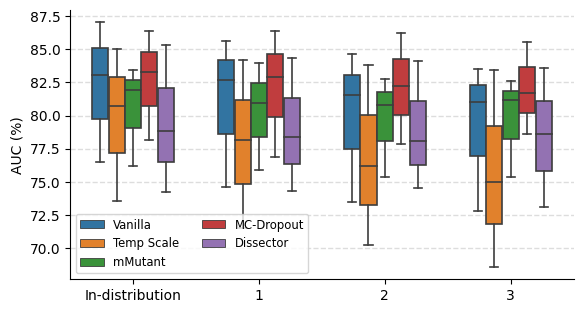

In [223]:
# Reshape the data using melt function
data_melt = pd.melt(
    time_cs_df, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
plt.xlabel('')
plt.ylabel('AUC (%)')
plt.show()

#### Projectshift CS

In [318]:
dir = '../Uncertainty_Eval/'
task = 'CodeSummary_Module'
shift = 'different_project'

# project_cs_df = get_dataframe(shift, task)
# project_cs_df = project_cs_df[project_cs_df['Metric'] == 'AUC']
# project_cs_df

project_cs_df = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_project'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [81.2892, 85.3722, 82.5648, 82.9977, 82.8536, 82.5188,    86.8978, 88.5987, 89.5117, 88.0474, 90.2631, 90.9689,   91.4884, 88.9076, 86.6064, 91.5600, 87.7090, 87.5938],
    'Shift1':     [77.8627, 82.7522, 79.9355, 80.4149, 81.6695, 81.3008,    82.5598, 77.7263, 87.8978, 86.6201, 89.2601, 88.6126,   87.3997, 83.8937, 83.6484, 89.2702, 85.5348, 86.7621],
    'Shift2':     [75.7582, 80.3515, 77.7409, 78.9116, 78.8401, 79.4517,    80.5980, 78.8665, 85.4451, 83.9887, 87.4989, 86.4601,   85.0793, 84.0066, 81.6597, 88.4281, 83.0254, 84.8238],
    'Shift3':     [74.1181, 78.9998, 75.6045, 77.3065, 76.8322, 77.5220,    78.3853, 77.9501, 83.7071, 81.0400, 86.9043, 85.2681,   82.3378, 78.4503, 80.8207, 86.8490, 80.5739, 82.5028],
})

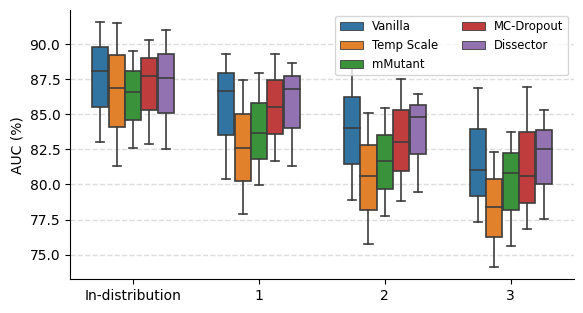

In [319]:
# Reshape the data using melt function
data_melt = pd.melt(
    project_cs_df, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
plt.xlabel('')
plt.ylabel('AUC (%)')
plt.show()